In [2]:
# !pip install torch==2.2
# !pip install torchvision
# !pip install seaborn
# !pip install numpy
# !pip install matplotlib
# !pip install torchsummary
# !pip install torchview
# !pip install graphviz
# !echo yevhenii | sudo -S apt-get install graphviz -y
# !pip install torchviz
# !pip install pandas

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torch.utils.data import random_split
import seaborn as sns
import numpy as np

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [3]:
BATCH_SIZE = 64
num_epoch = 20
learning_rate = 1e-4
class_size = 10

In [4]:
transform_train = transforms.Compose([transforms.Resize((224, 224)),
                                      transforms.RandomHorizontalFlip(p=0.7),
                                      transforms.ToTensor(),
                                      transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])

transform_test = transforms.Compose([transforms.Resize((224, 224)),
                                     transforms.ToTensor(),
                                     transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])

In [5]:
torch.manual_seed(2024)

train = torchvision.datasets.CIFAR100("./data-cifar100/", train=True, download=True, transform=transform_train)
test = torchvision.datasets.CIFAR100("./data-cifar100/", train=False, download=True, transform=transform_test)

val_size = 10000
train_size = 50000
# train_size = len(train) - val_size

# train, val = random_split(train, [train_size, val_size])

train_loader = DataLoader(train, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test, batch_size=BATCH_SIZE, shuffle=False)
# val_loader = DataLoader(val, batch_size=BATCH_SIZE, shuffle=False)

Files already downloaded and verified
Files already downloaded and verified


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


shape:  torch.Size([64, 3, 224, 224])


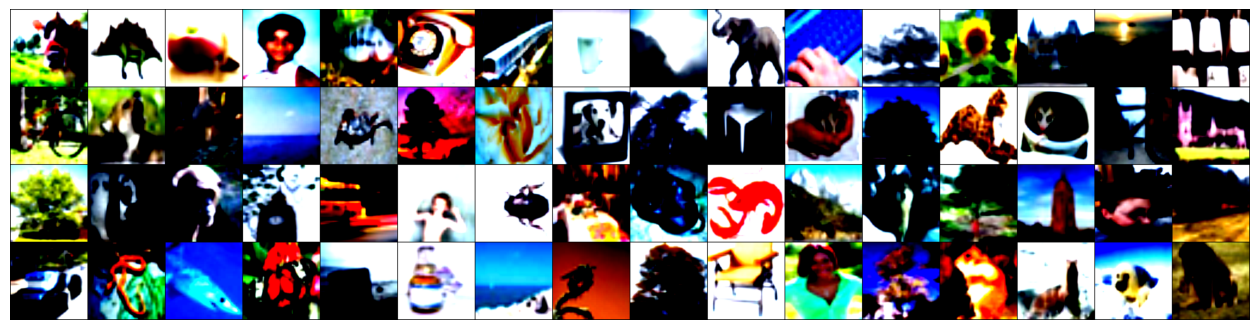

In [6]:
import matplotlib.pyplot as plt
from torchvision.utils import make_grid

for images, _ in train_loader:
    print('shape: ', images.shape)
    plt.figure(figsize=(16, 8))
    plt.axis('off')
    # plt.imshow(make_grid(images, nrow=16).permute((1, 2, 0)))
    plt.imshow(make_grid(images, nrow=16).permute((1, 2, 0)))
    break

In [7]:
from torchvision import models

# model = models.resnet18(pretrained=True)
model = torch.load("/mnt/c/phd/experiments/res/resnet_cifar_reference.pth")

In [8]:
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [9]:
# from torchsummary import summary

# summary(model.cuda(), (3, 224, 224))

In [10]:
# from torchview import draw_graph

# model_graph = draw_graph(model, input_size=(1, 3, 224, 224), expand_nested=True)
# model_graph.visual_graph

In [11]:
# input_last_year = model.fc.in_features
# model.fc = nn.Linear(input_last_year, 100)
# model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9, weight_decay=5e-4)

In [12]:
epoch_loss_history = []
epoch_acc_history = []

In [13]:

for epoch in range(num_epoch):
    epoch_avg_loss = 0
    for i, (imgs, labels) in enumerate(train_loader):
        imgs = imgs.to(device)
        labels = labels.to(device)

        labels_hat = model(imgs)
        n_corrects = (labels_hat.argmax(axis=1) == labels).sum().item()
        loss_value = criterion(labels_hat, labels)
        loss_value.backward()
        optimizer.step()
        optimizer.zero_grad()

        epoch_avg_loss += loss_value.item()
        
        accuracy = (n_corrects / labels.size(0)) * 100

        if (i+1) % 250 == 0:
            print(f'epoch {epoch + 1}/{num_epoch}, step: {i + 1}/{train_size/BATCH_SIZE}: loss = {loss_value:.5f}, acc = {accuracy:.2f}')
    
    epoch_loss_history.append(epoch_avg_loss / len(train_loader))

    with torch.no_grad():
        correct = 0
        samples = 0

        for i, (images, labels) in enumerate(test_loader):
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, predictions = outputs.max(1)
            correct += (predictions == labels).sum()
            samples += predictions.size(0)
        
        accuracy = float(correct) / float(samples) * 100
        epoch_acc_history.append(accuracy)

        print(f"epoch {epoch + 1}/{num_epoch}, val accuracy = {accuracy:.2f}%. Correct {correct} out of {samples} samples")

epoch 1/20, step: 250/781.25: loss = 1.05176, acc = 68.75
epoch 1/20, step: 500/781.25: loss = 0.94088, acc = 79.69
epoch 1/20, step: 750/781.25: loss = 0.99462, acc = 75.00
epoch 1/20, val accuracy = 72.05%. Correct 7205 out of 10000 samples
epoch 2/20, step: 250/781.25: loss = 0.98781, acc = 70.31
epoch 2/20, step: 500/781.25: loss = 0.90876, acc = 78.12
epoch 2/20, step: 750/781.25: loss = 0.95573, acc = 78.12
epoch 2/20, val accuracy = 72.53%. Correct 7253 out of 10000 samples
epoch 3/20, step: 250/781.25: loss = 0.93987, acc = 71.88
epoch 3/20, step: 500/781.25: loss = 0.91591, acc = 78.12
epoch 3/20, step: 750/781.25: loss = 0.90322, acc = 79.69
epoch 3/20, val accuracy = 72.90%. Correct 7290 out of 10000 samples
epoch 4/20, step: 250/781.25: loss = 0.88347, acc = 73.44
epoch 4/20, step: 500/781.25: loss = 0.88418, acc = 76.56
epoch 4/20, step: 750/781.25: loss = 0.87261, acc = 79.69
epoch 4/20, val accuracy = 73.37%. Correct 7337 out of 10000 samples
epoch 5/20, step: 250/781.25

[4.663135051727295, 4.671868324279785, 4.66538667678833, 4.6084065437316895, 4.698480606079102, 4.723874568939209, 4.687114715576172, 4.672508239746094, 4.6861772537231445, 4.576818466186523, 4.769344806671143, 4.697547912597656, 4.7462568283081055, 4.668595314025879, 4.623442649841309, 4.688260555267334, 4.721158027648926, 4.72523832321167, 4.644040584564209, 4.736287593841553, 4.669398784637451, 4.73934268951416, 4.609602928161621, 4.6068878173828125, 4.64089298248291, 4.661510467529297, 4.4884467124938965, 4.663497447967529, 4.549627304077148, 4.65135383605957, 4.649502754211426, 4.609832763671875, 4.637568950653076, 4.561452865600586, 4.567790985107422, 4.626392364501953, 4.600863933563232, 4.632875442504883, 4.643658638000488, 4.665079593658447, 4.619515895843506, 4.621294975280762, 4.600376605987549, 4.619861602783203, 4.586030960083008, 4.610846519470215, 4.6192522048950195, 4.587116241455078, 4.546890735626221, 4.59303092956543, 4.599392414093018, 4.644643783569336, 4.603154659

[0.0, 1.5625, 0.0, 3.125, 1.5625, 0.0, 0.0, 1.5625, 0.0, 3.125, 1.5625, 1.5625, 1.5625, 0.0, 3.125, 3.125, 1.5625, 1.5625, 0.0, 0.0, 0.0, 1.5625, 3.125, 3.125, 1.5625, 3.125, 0.0, 1.5625, 1.5625, 1.5625, 1.5625, 0.0, 3.125, 3.125, 3.125, 0.0, 1.5625, 0.0, 1.5625, 0.0, 1.5625, 1.5625, 1.5625, 1.5625, 4.6875, 0.0, 3.125, 1.5625, 0.0, 0.0, 1.5625, 3.125, 4.6875, 0.0, 1.5625, 1.5625, 1.5625, 1.5625, 1.5625, 3.125, 3.125, 3.125, 3.125, 3.125, 4.6875, 0.0, 0.0, 1.5625, 4.6875, 1.5625, 0.0, 3.125, 1.5625, 4.6875, 1.5625, 1.5625, 1.5625, 0.0, 0.0, 3.125, 0.0, 6.25, 3.125, 0.0, 0.0, 3.125, 0.0, 0.0, 0.0, 3.125, 1.5625, 0.0, 1.5625, 1.5625, 4.6875, 4.6875, 1.5625, 1.5625, 3.125, 6.25, 1.5625, 1.5625, 1.5625, 3.125, 6.25, 4.6875, 3.125, 4.6875, 0.0, 1.5625, 3.125, 3.125, 1.5625, 0.0, 3.125, 3.125, 3.125, 3.125, 4.6875, 0.0, 4.6875, 1.5625, 0.0, 3.125, 3.125, 1.5625, 1.5625, 4.6875, 1.5625, 1.5625, 0.0, 9.375, 6.25, 1.5625, 1.5625, 0.0, 3.125, 3.125, 1.5625, 1.5625, 4.6875, 3.125, 9.375, 4.6875, 3

In [14]:
print(epoch_loss_history)
with open('/mnt/c/phd/experiments/res/history/resnet_cifar_refrence_loss_history-2.txt', "w") as f:
    for item in epoch_loss_history:
        f.write(f'{item:.5f}\n')

[0.9600061679740086, 0.9213556606141503, 0.8878376028117012, 0.8568067157359989, 0.826301294786241, 0.799544572715869, 0.7745289846759318, 0.7518161172071076, 0.7278051463615559, 0.7063149958086745, 0.6879059701319545, 0.668111701222027, 0.6491063588568012, 0.6313316756502136, 0.6131495342535132, 0.5972038281848059, 0.580828531395139, 0.5667782654542752, 0.551296198611979, 0.53802573021568]


In [15]:
print(epoch_acc_history)
with open('/mnt/c/phd/experiments/res/history/resnet_cifar_refrence_acc_history-2.txt', "w") as f:
    for item in epoch_acc_history:
        f.write(f'{item:.5f}\n')

[72.05, 72.53, 72.89999999999999, 73.37, 73.89, 74.36, 74.37, 74.59, 74.78, 75.12, 75.38, 75.53999999999999, 75.8, 75.78, 76.08, 76.27000000000001, 76.4, 76.49000000000001, 76.61, 76.74]


In [ ]:
# import pandas as pd

# test_loader = DataLoader(test, batch_size=BATCH_SIZE, shuffle=False)
# total_corrects =  0

# classes = set()

# for imgs, labels in test_loader:
#         for i in range(len(labels)):
#                 classes.add(labels[i])

# heatmap = pd.DataFrame(data=0, index=list(classes), columns=list(classes))

# with torch.no_grad():
#         for imgs, labels in test_loader:
#                 imgs = imgs.to(device)
#                 labels = labels.to(device)

#                 output = model(imgs)
#                 _, predicted = torch.max(output, 1)


#                 for i in range(labels.size(0)):
#                         if labels[i].item() == predicted[i].item():
#                                 total_corrects += 1
                        
#                         heatmap.iloc[labels[i].item(), predicted[i].item()] += 1

# _, ax = plt.subplots(figsize=(10, 8))
# ax = sns.heatmap(heatmap, annot=True, fmt="d", cmap="YlGnBu")
# plt.show()

In [16]:
torch.save(model, '/mnt/c/phd/experiments/res/resnet_cifar_reference-2.pth')